# <center> Topic Modelling </center> 

In [2]:
import pandas as pd
import numpy as np

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
data = pd.read_pickle('../data/processed/transcripts_1994_2021_lematized.pkl')
data.head()

,start_line,end_line,type,lines,votes,deputy_name,meeting_date,deputy_id,lines_processed,lines_lemmatized
0,630,678,65100001,"[АБАЛАКОВ А. Н., фракция КПРФ. ...",[],Абалаков Александр Николаевич,2016-06-15 00:00:00,99111772,фракция кпрф уважаемый сергей евгеньевич уважа...,"[фракция, кпрф, уважаемый, сергей, евгеньевич,..."
1,1476,1479,,"[АБАЛАКОВ А. Н., фракция КПРФ. ...",[],Абалаков Александр Николаевич,2015-12-02 00:00:00,99111772,фракция кпрф прошу вынести на отдельное голосо...,"[фракция, кпрф, просить, вынести, отдельный, г..."
2,2518,2522,,[АБАЛАКОВ А. Н. Поправка предполагает увеличен...,[],Абалаков Александр Николаевич,2015-12-02 00:00:00,99111772,поправка предполагает увеличение взноса на кап...,"[поправка, предполагать, увеличение, взнос, ка..."
3,4862,4874,65100003,"[АБАЛАКОВ А. Н., фракция КПРФ. ...",[],Абалаков Александр Николаевич,2015-11-20 00:00:00,99111772,фракция кпрф уважаемый сергей евгеньевич уважа...,"[фракция, кпрф, уважаемый, сергей, евгеньевич,..."
4,4672,4716,,"[АБАЛАКОВ А. Н., фракция КПРФ. ...",[],Абалаков Александр Николаевич,2015-11-18 00:00:00,99111772,фракция кпрф уважаемый сергей евгеньевич уважа...,"[фракция, кпрф, уважаемый, сергей, евгеньевич,..."


In [4]:
data['meeting_date'] = pd.to_datetime(data['meeting_date'])
data['year'] = data['meeting_date'].dt.year

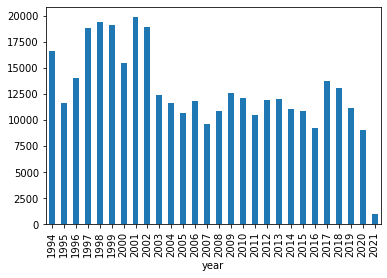

In [5]:
discussions_per_year = data.groupby(['year'])['meeting_date'].count()
discussions_per_year.plot.bar()

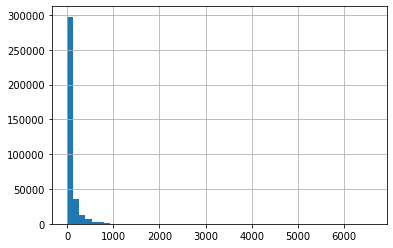

In [6]:
data['lenght'] = data['lines_lemmatized'].apply(len)
data['lenght'].hist(bins=50)

In [8]:
data[data['lenght']>=50].shape

(177650, 12)

In [15]:
# removing short texts
data = data[data['lenght']>=30].reset_index(drop=True)

# Selecting a subset of data for hyperparameter tuning

In [18]:
stratified_data = []
for year in range(1994, 2021):
    stratified_data.append(data[data['year'].isin([year])].sample(2000))
stratified_data = pd.concat(stratified_data)
stratified_data.shape

(54000, 12)

In [19]:
data_words = stratified_data['lines_lemmatized'].to_numpy()

In [20]:
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [21]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in tqdm_notebook(texts, leave=False)]

In [22]:
data_words_bigrams = make_bigrams(data_words)

  0%|          | 0/54000 [00:00<?, ?it/s]

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

In [24]:
print(f'Размер словаря до фильтрации: {len(id2word)}')

Размер словаря до фильтрации: 100138


In [25]:
id2word.filter_extremes(no_below=3, no_above=0.5)
print(f'Размер словаря после фильтрации: {len(id2word)}')

Размер словаря после фильтрации: 65583


In [26]:
# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tqdm_notebook(texts, leave=False)]

  0%|          | 0/54000 [00:00<?, ?it/s]

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    
    Credits: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm_notebook(range(start, limit, step)):
        
        model = gensim.models.ldamulticore.LdaMulticore(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics, 
            random_state=42,
            chunksize=100,
            passes=10,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word, 
    corpus=corpus, 
    texts=texts, 
    start=5, limit=55, step=5
)

  0%|          | 0/10 [00:00<?, ?it/s]

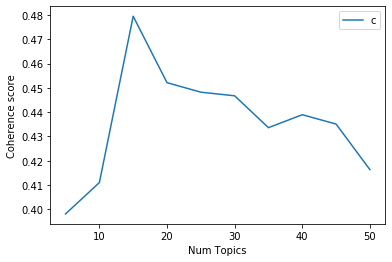

In [29]:
x = range(5, 55, 5)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Training on full data

In [30]:
%%time
data_words = data['lines_lemmatized'].to_numpy()

bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_words_bigrams = make_bigrams(data_words)
id2word = corpora.Dictionary(data_words_bigrams)
print(f'Размер словаря до фильтрации: {len(id2word)}')
id2word.filter_extremes(no_below=3, no_above=0.5)
print(f'Размер словаря после фильтрации: {len(id2word)}')

# Create Corpus
texts = data_words_bigrams
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tqdm_notebook(texts, leave=False)]

  0%|          | 0/241999 [00:00<?, ?it/s]

Размер словаря до фильтрации: 202859
Размер словаря после фильтрации: 100000


  0%|          | 0/241999 [00:00<?, ?it/s]

CPU times: user 3min 31s, sys: 4.94 s, total: 3min 36s
Wall time: 3min 37s


In [32]:
%%time
final_model = gensim.models.ldamulticore.LdaMulticore(
            corpus=corpus,
            id2word=id2word,
            num_topics=15, 
            random_state=42,
            chunksize=100,
            passes=10,
        )

CPU times: user 53min 44s, sys: 29min 12s, total: 1h 22min 57s
Wall time: 1h 17min 57s


In [33]:
coherencemodel = CoherenceModel(model=final_model, texts=texts, dictionary=id2word, coherence='c_v')
coherencemodel.get_coherence()

0.49891786092135254

In [34]:
final_model.save('../src/models/final_model_30_topics')

In [35]:
import pickle
with open('../src/models/corpus', 'wb') as f:
    pickle.dump(corpus, f)

In [36]:
data.shape

(241999, 12)

In [37]:
data.to_pickle('../data/processed/transcripts_1994_2021_processed.pkl')